### Helper Classes

First we get all of our helper modules. The prepare_EMG module will prepare the EMG data for phoneme recognition. The prepare_outputs module will prepare our target labels and align them with our EMG data. The module 'prepare_data' will help us read data from CSV into a dataframe.

In [1]:
%load_ext autoreload
%autoreload 2

import prepare_EMG, prepare_outputs, prepare_data, pandas

EMG_Prep = prepare_EMG.EMG_preparer()
Output_Prep = prepare_outputs.output_preparer()
Data_Prep = prepare_data.data_preparer()



#### Loading the Data

We use the prepare_data helper class to load files from "simple-svr-data". These files have a single word per file, making phoneme labeling relatively straightforward. 

In [2]:
singles_1 = Data_Prep.load_singletons(1)
singles_2 = Data_Prep.load_singletons(2)
singles_3 = Data_Prep.load_singletons(3)

# print(singles_1.keys())

File b'simple-svr-data/raspy-1' does not exist
File b'simple-svr-data/direful-2' does not exist
File b'simple-svr-data/wrathful-2' does not exist
File b'simple-svr-data/direful-3' does not exist
File b'simple-svr-data/wrathful-3' does not exist


### Labeling the Data

First, we generate the phoneme and articulatory feature labels from each word. We'll use these to process the data in each file based on the length of the file and how many phonemes it should contain. We perform CWT, the continuous wavelet transform on the EMG data to help differentiate MUAP activity. We scale the CWT windows relative to the length of time we expect an even distribution of phonemes across the file to have. 

In [3]:
from scipy import signal
import numpy as np


labels = {}
windows = {}
for word in singles_1:
    try:
        label = Output_Prep.transform(word)
        num_phonemes = label.shape[0]
        label = label.append(Output_Prep.transform(word))
        label = label.append(Output_Prep.transform(word))
        labels[word] = label
        widths = np.linspace(0.01,10,50)
        wt_out = signal.cwt(singles_1[word]['voltage'], signal.ricker, widths)
        wt_out = pandas.DataFrame(wt_out).T
        windows[word] = EMG_Prep.process(wt_out, num_phonemes, wavelets=True)
        wt_out_2 = signal.cwt(singles_2[word]['voltage'], signal.ricker, widths)
        wt_out_2 = pandas.DataFrame(wt_out_2).T
        windows[word] = windows[word].append(EMG_Prep.process(wt_out_2, num_phonemes, wavelets=True))
        wt_out_3 = signal.cwt(singles_3[word]['voltage'], signal.ricker, widths)
        wt_out_3 = pandas.DataFrame(wt_out_3).T
        windows[word] = windows[word].append(EMG_Prep.process(wt_out_3, num_phonemes, wavelets=True))
    except Exception as inst:
        print(inst)


'direful'
'wrathful'


#### Preparing Input, Output 'Master' DataFrames

Various output and input dataframes need to be concatenated together for later usage with cross-validation.

In [156]:
import pandas
%autoreload 2

y = pandas.DataFrame()
X = pandas.DataFrame()
for word in labels:
#     append labels to the master label dataframe
    label_frame = labels[word]
    y = y.append(label_frame)
#     Use phonemes to name each series in 'windows' for that word
    window_frame = windows[word]
    if len(label_frame.axes[0]):
        window_frame = window_frame.rename_axis(lambda x: label_frame.axes[0][x])
        X = X.append(window_frame)
    else:
        print('no labels for:',word)

print(y.head(),X.head())

TypeError: list indices must be integers or slices, not str

#### Preprocessing, continued

Now that wavelet transforms have been applied to the EMG data, further processing is done. Scaling columns helps center features, PCA reduces the total number of features to just 10 of the most important ones, and normalization helps balance individual samples. 

In [5]:
# print(X.head(18), y.head(18))
from sklearn.preprocessing import scale,normalize
from sklearn.decomposition import PCA

X_scaled = scale(X)
pca = PCA(n_components=10, random_state=9)
X_reduced = pca.fit_transform(X_scaled)
X_normalized = normalize(X_reduced)

X_normalized = pandas.DataFrame(X_normalized)
X_normalized = X_normalized.rename_axis(lambda x: 'pc-'+str(x), axis='columns')
print(X_normalized)


          pc-0      pc-1      pc-2      pc-3      pc-4      pc-5      pc-6  \
0     0.576184 -0.754542 -0.050206 -0.239748  0.180560  0.053793 -0.032647   
1     0.013750 -0.926197  0.092969 -0.335421 -0.070407 -0.012713 -0.104847   
2     0.712272 -0.572587  0.364726 -0.101604 -0.016012 -0.044763 -0.106791   
3     0.798840 -0.474456  0.269973 -0.229070 -0.092277  0.010798  0.037415   
4     0.910146 -0.362559 -0.045496 -0.050948 -0.002132  0.121055 -0.139570   
5     0.088129 -0.771852 -0.391430  0.440707  0.000632 -0.166142 -0.041596   
6     0.681565 -0.326778  0.139038  0.580352 -0.104344 -0.211053 -0.038802   
7     0.797589 -0.451240  0.122891  0.304637  0.063912 -0.209512  0.023606   
8     0.766758 -0.488329  0.222714  0.331085 -0.022852 -0.106159  0.041693   
9     0.087474 -0.942711 -0.130225  0.237289  0.102326 -0.093718  0.074641   
10    0.729444  0.663096 -0.076655  0.129843 -0.048173  0.017302  0.026245   
11   -0.922918  0.200325 -0.105156  0.283830 -0.091174  0.010532

### Exploratory Visualizations

We use wavelet tranformations to visualize EMG data for a few words, to see how they can vary from series to series and between one another. X-axis of these graphs is file time (seconds), Y is the wavelet width relative to delta-t (the time between data points). Purple and green denote positive and negative phases, while color intensity corresponds to wave amplitude. Some patterns apparently correspond to specific phonemes, unifying words across different series. Variation between samples of a given word is also apparent. 

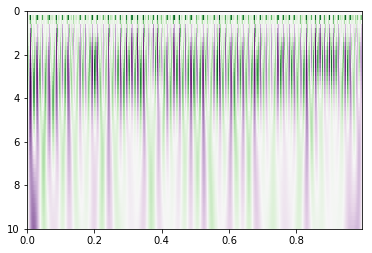

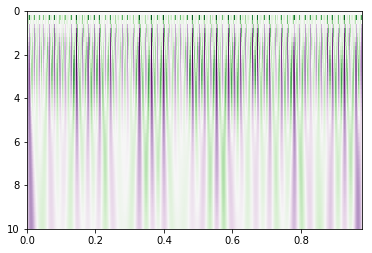

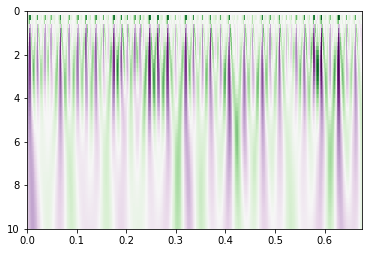

In [126]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

sig = singles_1['advice']['voltage']
length = len(sig)
dur = singles_1['advice']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T
# print(wt_out_frame.head())
sig = singles_2['advice']['voltage']
length = len(sig)
dur = singles_2['advice']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T

sig = singles_3['advice']['voltage']
length = len(sig)
dur = singles_3['advice']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T

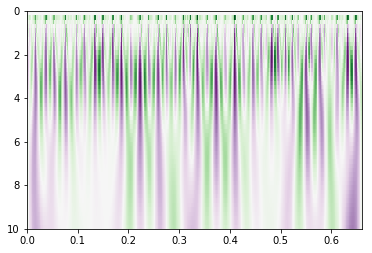

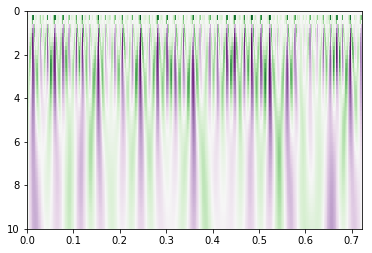

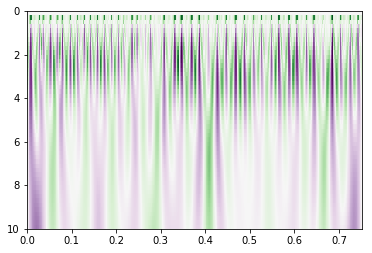

In [125]:
sig = singles_1['aspiring']['voltage']
length = len(sig)
dur = singles_1['aspiring']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T
# print(wt_out_frame.head())
sig = singles_2['aspiring']['voltage']
length = len(sig)
dur = singles_2['aspiring']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T

sig = singles_3['aspiring']['voltage']
length = len(sig)
dur = singles_3['aspiring']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T

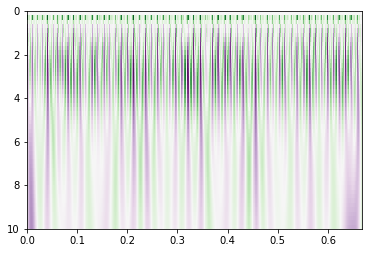

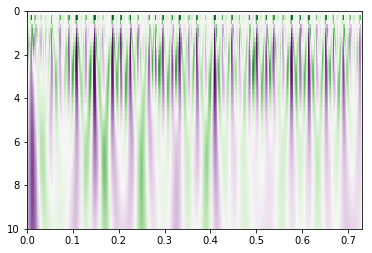

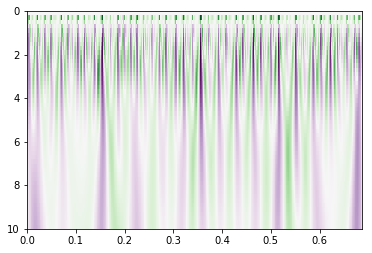

In [128]:
sig3 = singles_1['weather']['voltage']
length = len(sig)
dur = singles_1['weather']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig3, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()

sig3 = singles_2['weather']['voltage']
length = len(sig)
dur = singles_2['weather']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig3, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()

sig3 = singles_3['weather']['voltage']
length = len(sig)
dur = singles_3['weather']['time'][length-1]
widths = np.linspace(.01,10,50)
wt_out = signal.cwt(sig3, signal.ricker, widths)
# print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, dur, 10, .01],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()

### AF Extractor Models

These models will be optimized for extracting Articulatory Features from the data, before passing those AF's onto an MLPC for identifying the most likely phoneme. 

In [6]:
# Prepare lists of parameters for our GridSearch
# First, our layer sizes
layer_sizes = []
for i in range(2,5):
    for j in range(0,180,30):
        if j:
            tup = []
            for k in range(i):
                tup.append(j)
            layer_sizes.append(tuple(tup))
print('number layer sizes:',len(layer_sizes),'here be layer sizes',layer_sizes)

# Next, our alpha values
alphas = [0.0001,1,1000]

number layer sizes: 15 here be layer sizes [(30, 30), (60, 60), (90, 90), (120, 120), (150, 150), (30, 30, 30), (60, 60, 60), (90, 90, 90), (120, 120, 120), (150, 150, 150), (30, 30, 30, 30), (60, 60, 60, 60), (90, 90, 90, 90), (120, 120, 120, 120), (150, 150, 150, 150)]


### Preparing GridSearch and Assesing Stock MLPC as AF extractor models

We setup the objects for performing gridsearch on each one of the Articulatory Feature Extractor models. We also train untuned, stock MLPC models to serve as a performance baseline. We will compare the performance of these baseline, untuned models to our gridsearched models to determine whether gridsearch has in fact improved the model parameters for each AF extractor. 

In [7]:
from sklearn.neural_network import MLPClassifier as MLPC
# Import other models to try for feature extraction
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

import copy

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.15, random_state=12)

combined_features = FeatureUnion([
    ('pca',PCA(random_state=18)),
    ('kbest',SelectKBest(k=1))
])

pipeline = Pipeline([
#     ('features', combined_features),
    ('model', MLPC(random_state=12))
])


param_grid = {
#     'features__pca__n_components':[10,20,50],
    'model__solver':['adam'],
    'model__hidden_layer_sizes':layer_sizes,
    'model__activation':['relu'],
    'model__alpha': alphas,
    'model__max_iter':[200]
}


grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1)

manner_classifier = MLPC(solver='adam',random_state=3)
manner_classifier.fit(X_train, y_train['manner'])
m_score = manner_classifier.score(X_test, y_test['manner'])

place_classifier = MLPC(solver='adam',random_state=6)
place_classifier.fit(X_train, y_train['place'])
p_score = place_classifier.score(X_test, y_test['place'])

height_classifier = MLPC(solver='adam',random_state=9)
height_classifier.fit(X_train, y_train['height'])
h_score = height_classifier.score(X_test, y_test['height'])

vowel_classifier = MLPC(solver='adam',random_state=12)
vowel_classifier.fit(X_train, y_train['vowel'])
v_score = vowel_classifier.score(X_test, y_test['vowel'])

print('manner score:',m_score,'place score:',p_score,'height score:',h_score,'vowel score:',v_score)
# print(data_1_proc.head(50), trans_labels['manner'].head(50))

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


manner score: 0.357142857143 place score: 0.258928571429 height score: 0.473214285714 vowel score: 0.616071428571


In [8]:
manner_classifier2 = copy.deepcopy(grid_search)
manner_classifier2.fit(X_train, y_train['manner'])
m_score2 = manner_classifier2.score(X_test, y_test['manner'])

print('manner score:',m_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

manner score: 0.372023809524


In [9]:
place_classifier2 = copy.deepcopy(grid_search)
place_classifier2.fit(X_train, y_train['place'])
p_score2 = place_classifier2.score(X_test, y_test['place'])

print('place score:',p_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

place score: 0.285714285714


In [10]:
height_classifier2 = copy.deepcopy(grid_search)
height_classifier2.fit(X_train, y_train['height'])
h_score2 = height_classifier2.score(X_test, y_test['height'])

print('height score:',h_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

height score: 0.491071428571


In [11]:
vowel_classifier2 = copy.deepcopy(grid_search)
vowel_classifier2.fit(X_train, y_train['vowel'])
v_score2 = vowel_classifier2.score(X_test, y_test['vowel'])

print('vowel score:',v_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


vowel score: 0.627976190476


### Training the Solution and Benchmark Models

Training the solution model requires predicted AF's, using the optimized AFE models gridsearched in the previous step. Here is where the predictions are made and transformed into input features for the solution model before CV train-test splitting is performed. 

In [16]:
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import MultiLabelBinarizer as MLB
from sklearn.preprocessing import OneHotEncoder as OHE
from collections import Counter

manner_inputs = manner_classifier2.predict(X_normalized)
place_inputs = place_classifier2.predict(X_normalized)
height_inputs = height_classifier2.predict(X_normalized)
vowel_inputs = vowel_classifier2.predict(X_normalized)

# We need to account for each value that each category of label can take on
m_count = Counter()
p_count = Counter()
h_count = Counter()
v_count = Counter()

for row in range(y.shape[0]):
    m_count.update([y.iloc[row]['manner']])
    p_count.update([y.iloc[row]['place']])
    h_count.update([y.iloc[row]['height']])
    v_count.update([y.iloc[row]['vowel']])
    
counters = [m_count,p_count,h_count,v_count]

feature_dict = {}
for count in counters:
    current = 0
    for feature in count.keys():
        feature_dict[feature] = current
        current += 1
        
# Then, we transform the predicted labels with one-hot encoding after 
# concatenating the AF outputs and Solution Model Inputs
raw_inputs = copy.deepcopy(y)
for row in range(len(raw_inputs)):

    raw_inputs.iloc[row]['manner'] = manner_inputs[row]
    raw_inputs.iloc[row]['place'] = place_inputs[row]
    raw_inputs.iloc[row]['height'] = height_inputs[row]
    raw_inputs.iloc[row]['vowel'] = vowel_inputs[row]

num_labels = copy.deepcopy(raw_inputs)
for row in range(raw_inputs.shape[0]):
    m_feat = raw_inputs.iloc[row]['manner']
    p_feat = raw_inputs.iloc[row]['place']
    h_feat = raw_inputs.iloc[row]['height']
    v_feat = raw_inputs.iloc[row]['vowel']
    num_labels.iloc[row]['manner'] = feature_dict[m_feat]
    num_labels.iloc[row]['place'] = feature_dict[p_feat]
    num_labels.iloc[row]['height'] = feature_dict[h_feat]
    num_labels.iloc[row]['vowel'] = feature_dict[v_feat]

encoder = OHE()
new_labels = encoder.fit_transform(num_labels)
enc_labels = pandas.DataFrame(new_labels.toarray())

# Finally, we build our new input DataFrame with predicted AF's and processed EMG
X_cols = list(X_normalized.axes[1]) + list(enc_labels.axes[1])

phoneme_inputs = pandas.DataFrame(columns=X_cols)
phoneme_labels = y.axes[0]

for row in range(X.shape[0]):
    new_row = X_normalized.iloc[row].append(enc_labels.iloc[row])
    new_row.name = X_normalized.iloc[row].name
    phoneme_inputs = phoneme_inputs.append(new_row)
# We're ready to split our solution model data for CV
pho_X_train, pho_X_test, pho_y_train, pho_y_test = train_test_split(phoneme_inputs, phoneme_labels, test_size=0.15, random_state=12)

### Benchmark Optimization

A benchmark model is optimized and assessed, serving as a standard for the solution model to best.

In [20]:
pho2_X_train, pho2_X_test, pho2_y_train, pho2_y_test = train_test_split(X,phoneme_labels, test_size=0.15, random_state=12)

benchmark_gs = GridSearchCV(pipeline, param_grid, n_jobs=-1)

benchmark_gs.fit(pho2_X_train, pho2_y_train)
pho2_score = benchmark_gs.score(pho2_X_test,pho2_y_test)
print(pho2_score)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Conver

0.116071428571


### Solution Model

Here's where we actually optimize and test our benchmark model to see if adding AF's in the form of predictions from specialized AFE's is better than the baseline architecture. 

In [17]:
pho_layer_sizes = []
for i in range(2,10):
    for j in range(60,120,30):
        if j:
            tup = []
            for k in range(i):
                tup.append(j)
            pho_layer_sizes.append(tuple(tup))
print('number layer sizes:',len(pho_layer_sizes),'here be layer sizes',pho_layer_sizes)

# Next, our alpha values
pho_alphas = [0.001,0.1,1,1000]

param_grid = {
#     'features__pca__n_components':[10,20,50],
    'model__solver':['adam'],
    'model__hidden_layer_sizes':pho_layer_sizes,
    'model__activation':['relu'],
    'model__alpha': pho_alphas,
    'model__max_iter':[300]
}


pho_model_grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
# The Solution Model
phoneme_classifier = pho_model_grid_search
phoneme_classifier.fit(pho_X_train, pho_y_train)
pho_train_f1 = phoneme_classifier.score(pho_X_train, pho_y_train)
print('phoneme classifier training score:',pho_train_f1)

number layer sizes: 16 here be layer sizes [(60, 60), (90, 90), (60, 60, 60), (90, 90, 90), (60, 60, 60, 60), (90, 90, 90, 90), (60, 60, 60, 60, 60), (90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90, 90, 90, 90)]


/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Conver

phoneme classifier training score: 0.12532912059


In [19]:
pho_test_score = phoneme_classifier.score(pho_X_test, pho_y_test)
print('phoneme model test score:',pho_test_score)

phoneme model test score: 0.133928571429


### Various Stat Calculations

We calculate distributions of phonemes, various dataset statistics, detailed performance comparison between benchmark and solution, and inspection of the solution model.

D represents 4.429530201342282% of all samples
AH represents 9.261744966442953% of all samples
S represents 7.114093959731544% of all samples
T represents 7.785234899328859% of all samples
IY represents 4.026845637583892% of all samples
M represents 2.953020134228188% of all samples
AA represents 1.6107382550335572% of all samples
R represents 5.100671140939597% of all samples
CH represents 0.8053691275167786% of all samples
K represents 6.174496644295302% of all samples
P represents 3.48993288590604% of all samples
L represents 4.697986577181208% of all samples
UH represents 0.4026845637583893% of all samples
ER represents 2.953020134228188% of all samples
B represents 2.2818791946308723% of all samples
OY represents 0.1342281879194631% of all samples
Z represents 1.476510067114094% of all samples
W represents 1.74496644295302% of all samples
EY represents 1.476510067114094% of all samples
N represents 6.174496644295302% of all samples
V represents 1.6107382550335572% of all samples
I

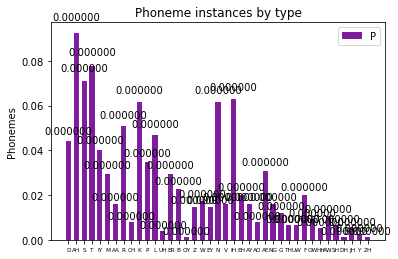

In [49]:
phonemes = Counter(phoneme_labels)
N = len(phonemes)

total = sum(phonemes.values())
for key in phonemes:
    phonemes[key] = phonemes[key] / total
    print(key, "represents", str(phonemes[key]*100)+"%","of all samples")
ind = np.arange(N)  # the x locations for the groups
width = .66       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, phonemes.values(), width, color='xkcd:purple')

# add some text for labels, title and axes ticks
ax.set_ylabel('Phonemes')
ax.set_title('Phoneme instances by type')
ax.set_xticks(ind)
ax.set_xticklabels(phonemes.keys(),size='xx-small')

ax.legend('Phonemes')


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()

In [87]:
num_phonemes = []
num_letters = []
for word in labels:
    label_length = len(labels[word].axes[0])
    phonemes = labels[word].axes[0].values[0:label_length/3]
    num_letters.append(len(word))
    num_phonemes.append(len(phonemes))
#     print(word, ",", labels[word].axes[0].values[0:label_length/3])
print('average word length:', np.mean(num_letters), '+/-',np.std(num_letters))
print('average num phonemes:', np.mean(num_phonemes), '+/-', np.std(num_phonemes))

average word length: 6.06756756757 +/- 1.95442036117
average num phonemes: 5.03378378378 +/- 1.94663792126


/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [96]:
import random

singles = [singles_1, singles_2, singles_3]
duration = 0
durations = []
dataframe_size = 0
dataframe_sizes = []
voltages = []
for single in singles:
    for word in single:
        length = len(single[word])
        dur = single[word]['time'][length-1]
        size = np.sum(single[word].memory_usage())
        duration += dur
        durations.append(dur)
        dataframe_size += size
        dataframe_sizes.append(size)
        avg_v = np.mean(single[word]['voltage'])
        voltages.append(avg_v)
print('total duration:', duration, "seconds")
print('standard deviation of duration:', np.std(durations))
print('total dataframe mem use:', dataframe_size)
print('standard deviation of dataframe mem usage:', np.std(dataframe_sizes))
print('average v:',np.mean(voltages), '+/-', np.std(voltages))

r_volts = []
r_durs = []
for i in range(6):
    r_key = random.choice(list(singles_2))
    length = len(singles_2[r_key])
    dur = singles_2[r_key]['time'][length-1]
    avg_v = np.mean(singles_2[r_key]['voltage'])
    std_v = np.std(singles_2[r_key]['voltage'])
    r_durs.append(dur)
    r_volts.append(avg_v)
    print(r_key, ',',avg_v,',',std_v)

total duration: 350.162225485 seconds
standard deviation of duration: 0.244133106451
total dataframe mem use: 5449352
standard deviation of dataframe mem usage: 3902.2963051
average v: -0.339004458746 +/- 0.0493281748652
squirrel , -0.30204236006051455 , 0.4087680802476309
imperfect , -0.3154505589145108 , 0.42149477071395663
increase , -0.3477746747737557 , 0.4290439560439675
copy , -0.29421186360182355 , 0.4117780509967171
country , -0.2985075672645739 , 0.40458648656837826
stingy , -0.2940061475409835 , 0.401572509595684


In [117]:
from sklearn.metrics import f1_score
import math

labels_list = list(set(pho_y_test.values))
labels_list.sort()
bm_score = benchmark_gs.score(pho2_X_test,pho2_y_test)
bm_f1 = f1_score(pho2_y_test, benchmark_gs.predict(pho2_X_test),average=None, labels=labels_list)
sol_score = phoneme_classifier.score(pho_X_test, pho_y_test)
sol_f1 = f1_score(pho_y_test, phoneme_classifier.predict(pho_X_test),average=None, labels=labels_list)

print(bm_score, sol_score, len(pho2_y_test), np.std(bm_f1), np.std(sol_f1), labels)
print('benchmark f1:',bm_f1, 'std error:', np.std(bm_f1)/math.sqrt(len(pho2_y_test)))
print('solution f1:',sol_f1, 'std error:', np.std(sol_f1)/math.sqrt(len(pho_y_test)))

for label in range(len(labels_list)):
    print(labels_list[label],',',bm_f1[label],',',sol_f1[label])

0.116071428571 0.133928571429 336 0.0800985638659 0.0660905341983 ['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'D', 'EH', 'ER', 'EY', 'F', 'G', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UW', 'V', 'W', 'Y', 'Z']
benchmark f1: [ 0.28571429  0.          0.25        0.          0.          0.          0.
  0.          0.          0.          0.25        0.          0.
  0.06153846  0.          0.          0.09677419  0.          0.          0.
  0.          0.          0.          0.          0.175       0.
  0.05633803  0.          0.          0.          0.          0.          0.        ] std error: 0.00436973490444
solution f1: [ 0.          0.          0.28235294  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.16666667  0.          0.          0.0952381   0.11111111  0.          0.
  0.          0.          0.          0.          0.14173228  0.
  0.14925373  0.          0.          0.  

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [131]:
phoneme_classifier.best_estimator_

Pipeline(steps=[('model', MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(90, 90, 90, 90, 90, 90, 90),
       learning_rate='constant', learning_rate_init=0.001, max_iter=300,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=12,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

### Sensitivity Testing

Tweaking optimal parameters slightly, we fit and test a slightly different version of the solution model to see how small changes in parameters affect performance. After that, we see how negative forcing, the uniform diminution of original values, affects the solution model's performance. Last is white noise testing, where Gaussian noise is added to each row. 

In [139]:
# Parameter Sensitivity test
sensitivity_1 = MLPC(hidden_layer_sizes=(60,60,60,60,60,60,60),alpha=.0001)
sensitivity_1.fit(pho_X_train, pho_y_train)
sens_1 = sensitivity_1.score(pho_X_test, pho_y_test)
print(sens_1)

0.125


time voltage
0.005366086959838867 -0.012890625


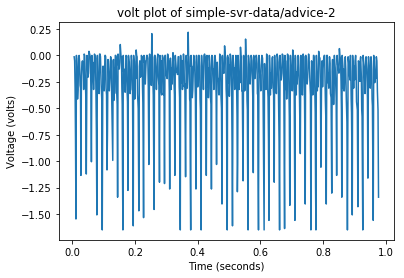

time voltage
0.00541996955871582 -0.012890625


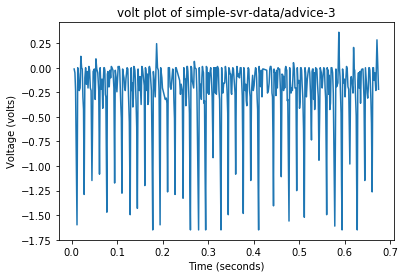

time voltage
0.004483938217163086 -0.605859375


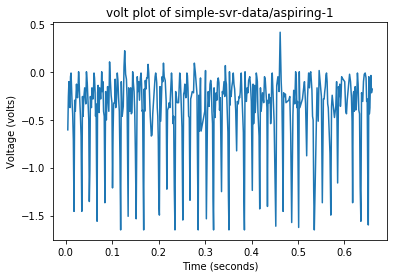

time voltage
0.004609823226928711 0.012890625


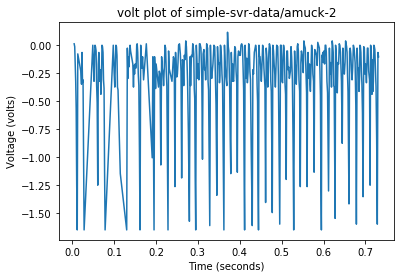

row-wise forcing score: 0.136904761905
column-wise forcing score: 0.133928571429
white noise addition: 0.116071428571


In [155]:
# Row-wise forcing sensitivity test
pho_X_test_rf = copy.deepcopy(pho_X_test)
pho_X_test_rf['pc-0'] = pho_X_test_rf['pc-0'] * random.random()
rf_test = phoneme_classifier.score(pho_X_test_rf, pho_y_test)
# Column-wise forcing sensitivity test
pho_X_test_cf = copy.deepcopy(pho_X_test)
pho_X_test_cf[1:100] = pho_X_test_rf[1:100] * random.random()
cf_test = phoneme_classifier.score(pho_X_test_cf, pho_y_test)
# Random white noise sensitivity test
pho_X_test_wn = copy.deepcopy(pho_X_test)
pho_X_test_wn.iloc[:,0:10] = pho_X_test_wn.iloc[:,0:10]+np.random.normal(0, 0.15, 10)
wn_test = phoneme_classifier.score(pho_X_test_wn, pho_y_test)

print('row-wise forcing score:', rf_test)
print('column-wise forcing score:', cf_test)
print('white noise addition:', wn_test)